In [43]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import sklearn
import utils
mpl.rcParams['pdf.fonttype'] = 42

## Benchmark

This jupyter notebook contains the performance of CHASMplus against other methods by using 5 mutation-level benchmarks (12 methods). We used multiple benchmarks because each individually has weaknesses, but, in aggregate, they span multiple scales of evaluation and amount of supportive evidence (Figure 2a). This is critical because mutations with the most established support for a driver role tend to be in a few well-understood cancer driver genes, but it otherwise would not be clear how generalizable performance would be for mutations in other genes. The benchmarks fall under three broad categories: in vitro experiments, high throughput in vivo screens, and literature-based assessments. We performed evaluations using the area under the Receiver Operating Characteristic Curve (auROC) (Figure 2e, Supplementary Figure 2, Supplementary Table 2), a common metric used in machine learning to describe how well predictions separate two classes without a priori selecting a score threshold, which for many methods is not well defined. In our assessment, the two classes represent likely driver and passenger mutation phenotypes represented by each benchmark. An auROC values of 0.5 is considered random prediction performance. 

#### Utility data

In [44]:
# data needed for formatting
format_benchmark_names = {
    'berger_et_al': 'Berger et al.',
    'berger_et_al_egfr': 'Berger et al. (EGFR)',
    'iarc_tp53': 'IARC TP53',
    'kim_et_al': 'Kim et al.',
    'mc3': 'CGC-recurrent',
    'msk_impact': 'Gene panel (OncoKB)',
    'patrick_et_al': 'Ng et al.'
}
rename_dict={'CHASM2':'raw CHASMplus'}

In [45]:
# cancer gene census genes
cgc = utils.process_cgc('CHASMplus/data/misc/Census_allSat Jan  7 18-57-49 2017.tsv')

### Kim et al

Kim et al. used a pooled in vivo screen approach by using competition of many mutations within a single pool. Mutations were transduced into HA1E-M cells, and pools were then injected into mice and then later assessed for representation of the mutation. Kim et al subsequently validated 71 alleles, individually, from the screen in NCR-Nu mice. We directly used the annotation of ‘functional’ (positive class) and ‘neutral’ (negative class) from the authors: tumors larger than 500 mm by 130 days as ‘functional’ and remaining mutations as ‘neutral’.

In [46]:
# read the results
df = pd.read_table('CHASMplus/data/benchmark/kim_et_al_results.txt').rename(columns=rename_dict)
# make larger scores mean more driver-like
df['CHASM'] = 1-df['CHASM']
df['SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']

# use the Kim et al. definition of 'functional'
df['y'] = (df['class']=='functional').astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASMplus'] = df['driver score'] * df['raw CHASMplus']

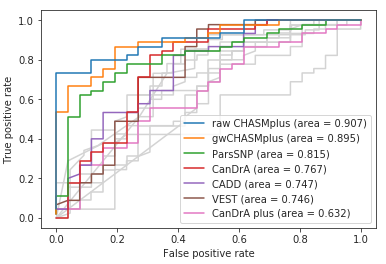

In [48]:
top_methods, other_methods = utils.fetch_methods('CHASMplus/data/benchmark/kim_et_al_comparison.txt')
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2d.pdf')

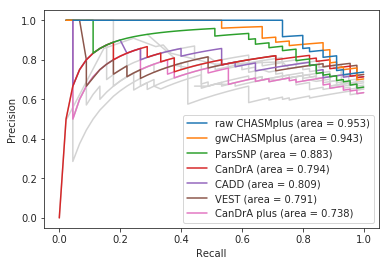

In [49]:
with sns.axes_style('ticks'):
    utils.pr_curve(df, top_methods, other_methods)

### IARC TP53

We assessed each methods ability to distinguish TP53 mutations with low transactivation (positive class) versus all other TP53 mutations (negative class). We evaluated all missense mutations (n=2,314) for TP53 from the IARC TP53 database. Low transactivation was considered as less than 50% wildtype, as indicated by the median of 8 different targets (WAF1, MDM2, BAX, h1433s, AIP1, GADD45, NOXA, and P53R2).

In [50]:
# read data
df = pd.read_table('CHASMplus/data/benchmark/iarc_tp53_results.txt').rename(columns=rename_dict)
df['CHASM'] = 1-df['CHASM']
df['SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']

# less than 50% wild type
df['y'] = (df['class']<50).astype(int)

# calculate chasm2 genome scores
rf_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASMplus'] = df['driver score'] * df['raw CHASMplus']

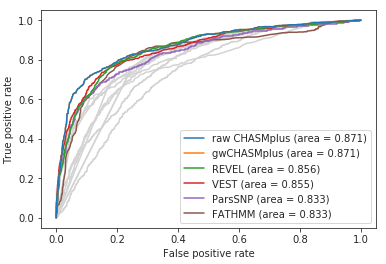

In [55]:
top_methods, other_methods = utils.fetch_methods('CHASMplus/data/benchmark/iarc_tp53_comparison.txt')
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2c.pdf')

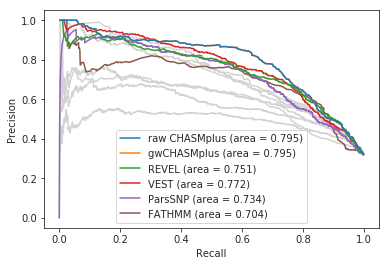

In [56]:
with sns.axes_style('ticks'):
    utils.pr_curve(df, top_methods, other_methods)

### Ng et al. (large in vitro assay)

In [57]:
df = pd.read_table('CHASMplus/data/benchmark/patrick_et_al_results.txt').rename(columns=rename_dict)
df = df[df['class'].isin(['activating', 'neutral', ])]
df['CHASM'] = 1-df['CHASM']
df['SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']

# label activating mutations as positive
df['y'] = (df['class'].isin(['activating',])).astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASMplus'] = df['driver score'] * df['raw CHASMplus']

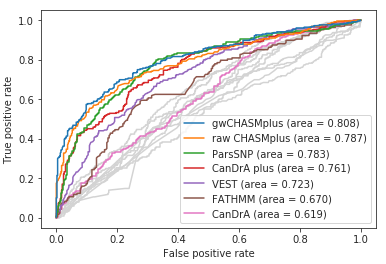

In [61]:
top_methods, other_methods = utils.fetch_methods('CHASMplus/data/benchmark/patrick_et_al_comparison.txt')
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2b.pdf')

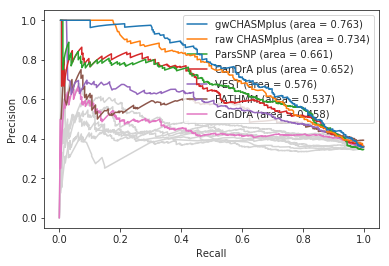

In [62]:
with sns.axes_style('ticks'):
    utils.pr_curve(df, top_methods, other_methods)

### Gene panel (MSK-IMPACT/OncoKB)

We obtained all missense mutations from the MSK-IMPACT gene panel of 414 cancer-related genes {Zehir, 2017 #3}. Mutations were annotated against OncoKB (downloaded 4/3/2017), if the oncogenicity annotation was available for an individual mutation. OncoKB is a literature-backed knowledge base that annotates the cancer driver and actionability status of mutations. We regarded any mutation labeled as ‘Oncogenic’ or ‘Likely Oncogenic’ as the positive class for evaluation with remaining mutations considered as negative.


In [63]:
# read data
df = pd.read_table('CHASMplus/data/benchmark/msk_impact_results.txt').rename(columns=rename_dict)
df['class'] = df['class'].fillna('no annotation')
df['CHASM'] = 1-df['CHASM']
df['SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']

# either 'oncogenic' or 'likely oncogenic' are positive class
df['y'] = (df['class'].isin(['Oncogenic', 'Likely Oncogenic'])).astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASMplus'] = df['driver score'] * df['raw CHASMplus']

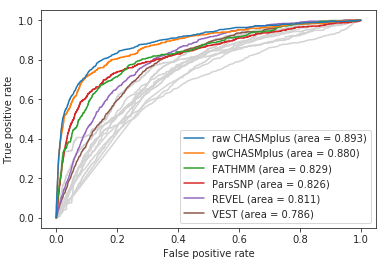

In [64]:
top_methods, other_methods = utils.fetch_methods('CHASMplus/data/benchmark/msk_impact_comparison.txt')
is_missense = df.HGVSp_Short.str.match('^p.[A-Z][0-9]+[A-Z]$').fillna(False)
with sns.axes_style('ticks'):
    utils.roc_plot(df[is_missense], top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2f.pdf')

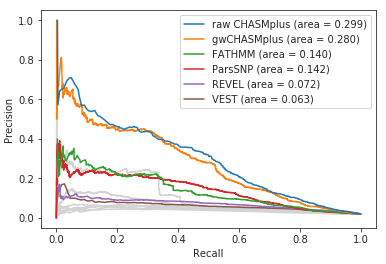

In [65]:
with sns.axes_style('ticks'):
    utils.pr_curve(df[is_missense], top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2i.pdf')

### CGC-recurrent

We examined driver prioritization on an exome-scale through a combined literature/heuristic evaluation. We first obtained a set of curated likely driver genes from the Cancer Gene Census (CGC, COSMIC v79). We restricted to only genes that were labeled as somatic and marked as relevant for missense mutations. We then labeled all recurrent missense mutations (n>1) in CGC genes as the positive class, and remaining mutations as the negative class.


In [66]:
# read results
df = pd.read_table('CHASMplus/data/benchmark/mc3_results.txt')
df['SIFT'] = 1 - df['SIFT']
df['CHASM'] = 1 - df['CHASM']
df['FATHMM'] = -df['FATHMM']

# get the protein position of the mutation
df['Protein_position'] = df['HGVSp_Short'].str.extract('^p\.[A-Z]([0-9]+)[A-Z]$')

In [67]:
# merge in chasm2 scores
useful_cols = ['UID', 'p.value..0.', 'driver score', 'CHASM2', 'CHASM2_genome', 'CHASM2_pval', 'CHASM2_genome_pval', 'CHASM2_qval', 'CHASM2_genome_qval',]
chasm2_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.txt', usecols=useful_cols).rename(columns={'driver':'CHASM2'})
df = pd.merge(df, chasm2_df, on='UID', how='left')

In [68]:
# merge in recurrence information
useful_cols = ['Hugo_Symbol', 'HGVSp_Short', 'Protein_position', 'Variant_Classification', 'Tumor_Sample_Barcode', 'CODE']
#mut_df = pd.read_table('data/input.pancan.maf', usecols=useful_cols)
mut_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.maf')
is_missense = mut_df['Variant_Classification']=='Missense_Mutation'
#mut_cts = mut_df[is_missense].groupby(['Hugo_Symbol', 'HGVSp_Short']).size().reset_index(name='recurrence')
#mut_df['Protein_position'] = mut_df['HGVSp_Short'].str.extract('^p\.[A-Z]([0-9]+)[A-Z]$')
mut_cts = mut_df[is_missense].groupby(['Hugo_Symbol', 'Protein_position']).size().reset_index(name='recurrence')
#df = pd.merge(df, mut_cts, on=['Hugo_Symbol', 'HGVSp_Short'], how='left')
df = pd.merge(df, mut_cts, on=['Hugo_Symbol', 'Protein_position'], how='left')

In [70]:
# mark CGC genes
df['CGC'] = 0
df.loc[df.Hugo_Symbol.isin(cgc), 'CGC'] = 1

# define class based on recurrent missense mutations in CGC genes
df['class'] = 'likely neutral'
is_recur_cgc = (df['CGC']==1) & (df['recurrence']>1)
df.loc[is_recur_cgc, 'class'] = 'recurrent'
df['y'] = (df['class']=='recurrent').astype(int)

# rename column
df = df.rename(columns={'CHASM2_genome': 'gwCHASMplus', 'CHASM2': 'raw CHASMplus'})

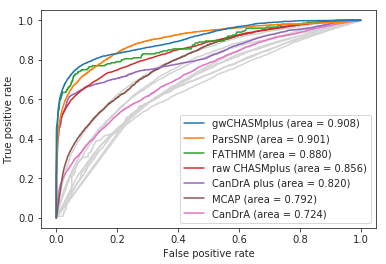

In [71]:
top_methods, other_methods = utils.fetch_methods('CHASMplus/data/benchmark/mc3_comparison.txt')
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2e.pdf')

Based on the precision recall curve, CanDrA plus and FATHMM seem to perform quite well.

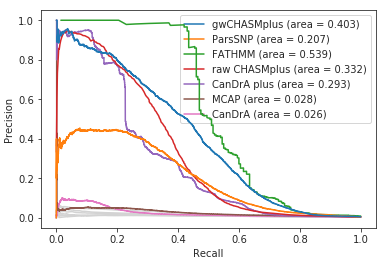

In [72]:
with sns.axes_style('ticks'):
    utils.pr_curve(df, top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2g.pdf')

However, interestingly, the performance of CanDrA plus and FATHMM drops substantially if TP53 mutations are not included in the benchmarks. This suggests the two methods may have overfit to TP53 and seemingly do not generalize as well to other genes. CHASMplus, on other hand, maintains a high PR auc, which is twice as high as the next best method.

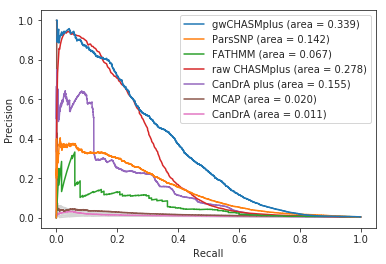

In [73]:
with sns.axes_style('ticks'):
    utils.pr_curve(df[(df["Hugo_Symbol"]!='TP53')], top_methods, other_methods)
    plt.savefig('CHASMplus/figures/figure_S2h.pdf')

### Correlation between scores

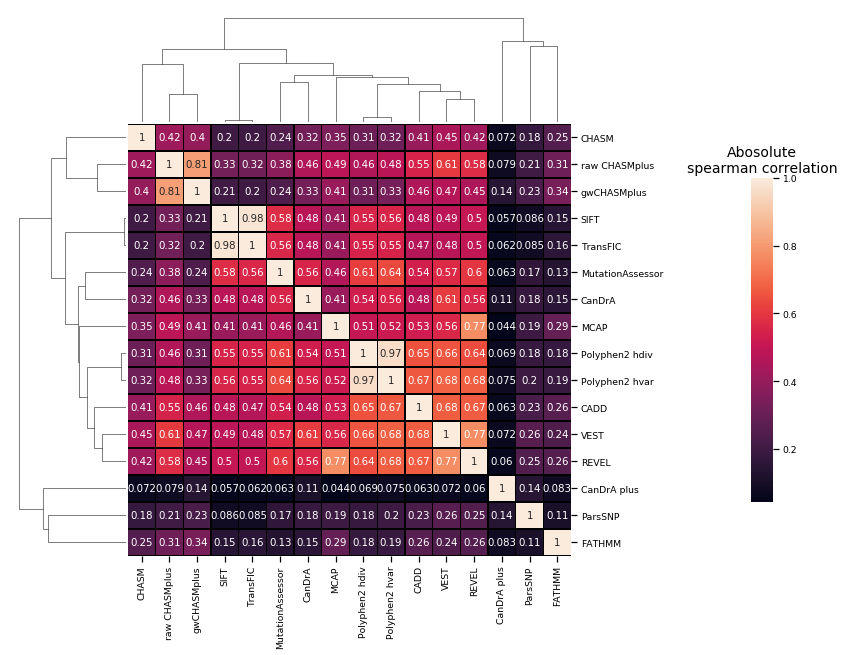

In [74]:
rename_dict = {
    'CHASM2_genome': 'gwCHASMplus', 
    'CHASM2': 'raw CHASMplus',
    'Polyphen2_hdiv': 'Polyphen2 hdiv', 
    'Polyphen2_hvar': 'Polyphen2 hvar',
    '1-SIFT': 'SIFT',
    '1-CHASM': 'CHASM'
}
methods = ['VEST', 'CADD','Polyphen2_hdiv', 'Polyphen2_hvar', 'SIFT', 'MutationAssessor',
           'REVEL', 'MCAP', 'ParsSNP', 'CanDrA', 'CanDrA plus', 'FATHMM',
           'CHASM', 'TransFIC',]
method_corr = df[methods+['raw CHASMplus', 'gwCHASMplus']].rename(columns=rename_dict).corr(method='spearman')

with sns.plotting_context('notebook', font_scale=.85):
    c = sns.clustermap(method_corr.abs(), annot=True, linewidth=.25, 
                   linecolor='black',
                   col_cluster=True, row_cluster=True,
                   fmt='.2g'
                  ) 
    _ = plt.setp(c.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    t = c.fig.axes[-1]
    t.set_title('Abosolute\nspearman correlation', size=14)
    
    # color bar on left
    c.cax.set_position([1.15, .2, .03, .45])
    
    # save figure
    plt.savefig('CHASMplus/figures/figure_S2a.pdf', bbox_inches='tight', bbox_extra_artists=[c.cax])

### Overall benchmark performance

#### Process results

In [75]:
# read the auROC comparisons
auc_dict = {}
pval_dict = {}
rank_dict = {}
for f in glob.glob('CHASMplus/data/benchmark/*_comparison.txt'):
    bench_name = os.path.basename(f)[:-15]
    if bench_name.startswith('berger'): continue
    tmp = pd.read_table(f)
    auc_dict[bench_name] = tmp['auc']
    pval_dict[bench_name] = tmp['pvalue']
    
    # figure out ranking
    polyphen_methods = ['Polyphen2_hvar', 'Polyphen2_hdiv']
    is_polyphen = tmp.method.isin(polyphen_methods)
    worst_polyphen = tmp.loc[is_polyphen, 'auc'].idxmin()
    chasm2_methods = ['raw CHASMplus', 'gwCHASMplus']
    is_chasm2 = tmp.method.isin(chasm2_methods)
    worst_chasm2 = tmp.loc[is_chasm2, 'auc'].idxmin()
    candra_methods = ['CanDrA', 'CanDrA.plus']
    is_candra = tmp.method.isin(candra_methods)
    worst_candra = tmp.loc[is_candra, 'auc'].idxmin()
    worst_methods = [worst_polyphen, worst_chasm2, worst_candra]
    rank_dict[bench_name] = tmp[~tmp.method.isin(worst_methods)]['auc'].rank(ascending=False)

# store the various metrics
auc_df = pd.DataFrame(auc_dict).T
pval_df = pd.DataFrame(pval_dict).T
rank_df = pd.DataFrame(rank_dict).T

In [76]:
# create a "best" column for chasm2, polyphen2, and candra
rank_df['CHASMplus'] = rank_df.loc[:, chasm2_methods].min(axis=1)
rank_df['Polyphen2'] = rank_df.loc[:, polyphen_methods].min(axis=1)
rank_df['CanDrA'] = rank_df.loc[:, candra_methods].min(axis=1)
pval_df['CHASMplus'] = pval_df.loc[:, chasm2_methods].min(axis=1)
pval_df['Polyphen2'] = pval_df.loc[:, polyphen_methods].min(axis=1)
pval_df['CanDrA'] = pval_df.loc[:, candra_methods].min(axis=1)
auc_df['CHASMplus'] = auc_df.loc[:, chasm2_methods].max(axis=1)
auc_df['Polyphen2'] = auc_df.loc[:, polyphen_methods].max(axis=1)
auc_df['CanDrA'] = auc_df.loc[:, candra_methods].max(axis=1)

# rename columns
col_rename = {'1-CHASM': 'CHASM', '1-SIFT': 'SIFT'}
auc_df = auc_df.rename(columns=col_rename)
pval_df = pval_df.rename(columns=col_rename)

# calculate the mean auc and mean rank across benchmarks
cols_of_interest = [u'CHASM', u'SIFT', u'CADD', u'FATHMM', u'MCAP', 
                    u'MutationAssessor', u'ParsSNP', 'TransFIC',
                    u'REVEL', u'VEST', u'CHASMplus', u'Polyphen2', u'CanDrA']
mean_auc = auc_df.mean()[cols_of_interest]
mean_rank = rank_df.mean()[cols_of_interest]
mean_auc.sort_values(inplace=True, ascending=False)

#### Heatmap

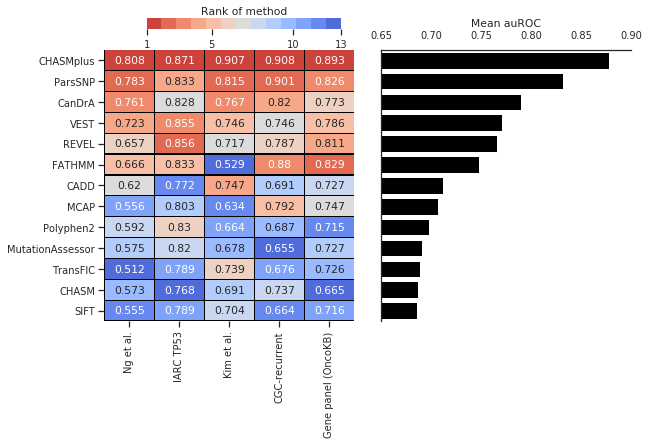

In [77]:
from matplotlib.colors import ListedColormap
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=.9):
    # create side-by-side subplots
    fig, axes = plt.subplots(1, 2)
    
    # prepare data for heatmap
    bench_order = ['patrick_et_al', 
                   #'berger_et_al_egfr', 
                   'iarc_tp53', 'kim_et_al', 
                   #'berger_et_al', 
                   'mc3', 'msk_impact']
    auc_plot = auc_df[cols_of_interest].T.fillna(.5).loc[mean_auc.index, bench_order]
    rank_plot = auc_df[cols_of_interest].T.rank(ascending=False).fillna(13).loc[mean_auc.index, bench_order]
    
    # plot heatmap
    cbar_ax = fig.add_axes([.22, .95, .3, .025])
    coolwarm = sns.color_palette('coolwarm', 13).as_hex()[::-1]
    coolwarm_cmap = ListedColormap(coolwarm)
    hm = sns.heatmap(rank_plot.rename(columns=format_benchmark_names), 
                     cmap=coolwarm_cmap,
                     annot=auc_plot,
                     fmt='.3g',
                     linewidth=.2,
                     linecolor='black',
                     ax=axes[0],
                     cbar_ax=cbar_ax,
                     cbar_kws={'orientation':'horizontal', 'ticks': [1, 5, 10, 13]})
                     #cbar_ax=cbar_ax, ax=ax,)
    cbar_ax.set_xlabel('Rank of method')
    cbar_ax.xaxis.set_label_position('top')

    # create a colored annotation bar for the different benchmarks
    #row_bar_ax = cbar_ax = fig.add_axes([.17, .00, .385, .025])
    #vals = [[0, 0, 0, 1, 1, 2, 2]]
    #vals = [[0, 0, 1, 2, 2]]
    #reg_pal = sns.color_palette().as_hex()
    #my_cmap = ListedColormap([reg_pal[1], reg_pal[4], reg_pal[5]])
    #my_cmap = ListedColormap([reg_pal[2], reg_pal[8], reg_pal[9]])
    #sns.heatmap(vals, cmap=my_cmap, ax=row_bar_ax, cbar=False, linecolor='black', linewidth=.25)

    # bar plot of mean auROC
    ax = axes[1]
    sns.barplot(mean_auc, mean_auc.index, color='black', ax=ax)
    ax.set_xlim(0.65, 0.9)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel('Mean auROC')
    sns.despine(right=True, bottom=True, top=False, ax=ax)
    
    # save figure
    fig.set_size_inches(9,6)
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_2e.pdf')

#### Create table

In [78]:
# prep dataframe marking significance with asterisks
pval_asterisk = pval_df[cols_of_interest].copy()
pval_asterisk.loc[:, :] = ''
pval_asterisk[pval_df<0.05] = '*'
pval_asterisk[pval_df<0.01] = '**'
pval_asterisk[pval_df<0.001] = '***'

# create supp table
formatted_auc = auc_df[cols_of_interest].applymap('{:.3g}'.format)
formatted_pval = pval_df[cols_of_interest].applymap('{:.1g}'.format)
supp_table_df = formatted_auc + pval_asterisk + " (" + formatted_pval + ")"

# rename columns to be more readable
bench_order = ['patrick_et_al', 'iarc_tp53', 'kim_et_al', 'mc3', 'msk_impact']
supp_table_df = supp_table_df.T[bench_order].rename(columns=format_benchmark_names).loc[mean_auc.index]

# save table
supp_table_df.to_csv('CHASMplus/results/table_S2.txt', sep='\t')

# show dataframe in notebook
supp_table_df

,Ng et al.,IARC TP53,Kim et al.,CGC-recurrent,Gene panel (OncoKB)
CHASMplus,0.808 (1),0.871 (1),0.907 (1),0.908 (1),0.893 (1)
ParsSNP,0.783* (0.05),0.833*** (2e-07),0.815* (0.03),0.901** (0.008),0.826*** (7e-14)
CanDrA,0.761** (0.007),0.828*** (3e-08),0.767* (0.02),0.82*** (2e-107),0.773*** (8e-47)
VEST,0.723*** (3e-05),0.855* (0.03),0.746** (0.007),0.746*** (0),0.786*** (3e-39)
REVEL,0.657*** (4e-11),0.856* (0.02),0.717** (0.002),0.787*** (3e-200),0.811*** (3e-27)
FATHMM,0.666*** (2e-10),0.833*** (1e-06),0.529*** (6e-10),0.88*** (0.0002),0.829*** (4e-16)
CADD,0.62*** (3e-15),0.772*** (3e-25),0.747** (0.007),0.691*** (0),0.727*** (2e-75)
MCAP,0.556*** (1e-21),0.803*** (2e-17),0.634*** (0.0002),0.792*** (5e-172),0.747*** (2e-67)
Polyphen2,0.592*** (3e-19),0.83*** (1e-15),0.664*** (8e-07),0.687*** (0),0.715*** (6e-100)
MutationAssessor,0.575*** (3e-19),0.82*** (1e-09),0.678*** (0.0002),0.655*** (0),0.727*** (1e-61)
